## Simple Exponential Smotthing (SES)

In [23]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

import os
import sys


sys.path.append(os.path.abspath('../..'))
from utils.db import get_db
from utils import find_missing_dates
from utils.fill_dates import fill_missing_dates
from utils.exponentially_weighted_moving_average import EWMA

In [4]:
engine = get_db()

In [5]:
query = """select sale_date, concat(product_code, ' - ', product_description) as product, sum(total_sales) as sales
from sales
where sale_date between '1/1/2025' and '6/1/2025'
and store_number='440'
and sale_type in ('Refunded', 'Sale')
and item_ring_type in ('ITEM', 'SUBD')
and product_code='84023020003.0'
group by sale_date, product_code, product_description
order by sale_date"""


In [6]:
ds = pd.read_sql(query, engine)

2025-06-06 15:40:15,143 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2025-06-06 15:40:15,144 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-06-06 15:40:15,215 INFO sqlalchemy.engine.Engine select current_schema()
2025-06-06 15:40:15,216 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-06-06 15:40:15,299 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2025-06-06 15:40:15,300 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-06-06 15:40:15,371 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-06-06 15:40:15,372 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname

In [7]:
missing = find_missing_dates(ds, 'sale_date', ds['sale_date'].min(), ds['sale_date'].max())
missing

[Timestamp('2025-03-14 00:00:00'),
 Timestamp('2025-03-24 00:00:00'),
 Timestamp('2025-04-02 00:00:00'),
 Timestamp('2025-04-11 00:00:00'),
 Timestamp('2025-05-21 00:00:00')]

In [8]:
ds = fill_missing_dates(ds, 'sale_date', 'sales', ds['sale_date'].min(), ds['sale_date'].max(), 0.01 )

In [28]:
ds.head(15)

,sale_date,product,sales,ses_pred,ewma
0,2025-02-24,84023020003.0 - AM CH MILK 1% GAL 128 OZ,25.83,25.830000,25.830000
1,2025-02-25,84023020003.0 - AM CH MILK 1% GAL 128 OZ,42.06,25.830000,29.076000
2,2025-02-26,84023020003.0 - AM CH MILK 1% GAL 128 OZ,29.52,29.076000,29.164800
3,2025-02-27,84023020003.0 - AM CH MILK 1% GAL 128 OZ,7.38,29.164800,24.807840
4,2025-02-28,84023020003.0 - AM CH MILK 1% GAL 128 OZ,18.45,24.807840,23.536272
5,2025-03-01,84023020003.0 - AM CH MILK 1% GAL 128 OZ,22.14,23.536272,23.257018
6,2025-03-02,84023020003.0 - AM CH MILK 1% GAL 128 OZ,40.59,23.257018,26.723614
7,2025-03-03,84023020003.0 - AM CH MILK 1% GAL 128 OZ,18.45,26.723614,25.068891
8,2025-03-04,84023020003.0 - AM CH MILK 1% GAL 128 OZ,52.02,25.068891,30.459113
9,2025-03-05,84023020003.0 - AM CH MILK 1% GAL 128 OZ,33.21,30.459113,31.009290


In [10]:
ses = SimpleExpSmoothing(ds['sales'])

In [11]:
ses

In [14]:
ds.index

RangeIndex(start=0, stop=98, step=1)

In [13]:
ds.index.freq = 'D'

In [15]:
res = ses.fit(smoothing_level=0.2, optimized=False)
res

In [16]:
res.predict(start=ds.index[0], end=ds.index[-1])

0     25.830000
1     25.830000
2     29.076000
3     29.164800
4     24.807840
        ...    
93    26.118826
94    26.799061
95    27.343249
96    26.302599
97    24.732079
Length: 98, dtype: float64

In [17]:
ds['ses_pred'] = res.predict(start=ds.index[0], end=ds.index[-1])

In [18]:
np.allclose(ds['ses_pred'], res.fittedvalues)

True

In [26]:
# lets add our EWMA column
ds['ewma'] = EWMA(ds['sales'], alpha=0.2)

In [ ]:
# if I shift this by -1, then they will line up perfectly
#ds['ses_pred'] = ds['ses_pred'].shift(-1)

<Axes: title={'center': 'Simple Exponential Smoothing'}, xlabel='sale_date'>

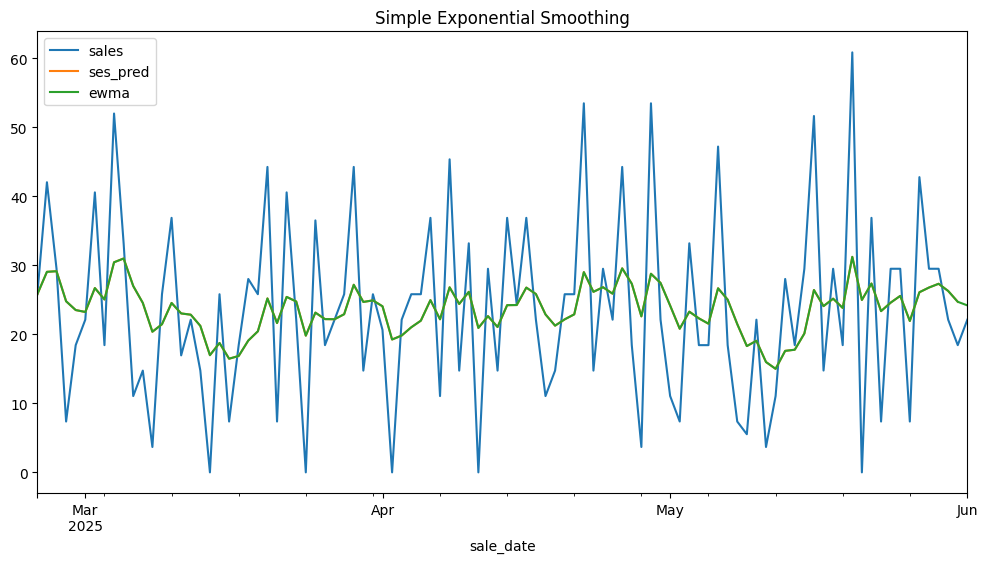

In [30]:
ds.plot(x='sale_date', y=['sales', 'ses_pred', 'ewma'], figsize=(12, 6), title='Simple Exponential Smoothing')

In [32]:
N_test = 7
train = ds.iloc[:-N_test]
test = ds.iloc[-N_test:]

In [49]:
ses = SimpleExpSmoothing(train['sales'], initialization_method='legacy-heuristic')
res = ses.fit(smoothing_level=0.2, optimized=False)

In [50]:
train_idx = ds.index <= train.index[-1]
test_idx = ds.index > train.index[-1]

In [51]:
ds.loc[train_idx, 'ses_fitted'] = res.fittedvalues
ds.loc[test_idx, 'ses_fitted'] = res.forecast(N_test)

In [52]:
ds.tail(14)

,sale_date,product,sales,ses_pred,ewma,ses_fitted
84,2025-05-19,84023020003.0 - AM CH MILK 1% GAL 128 OZ,18.45,23.840388,23.840388,25.187985
85,2025-05-20,84023020003.0 - AM CH MILK 1% GAL 128 OZ,60.88,31.248310,31.248310,23.840388
86,2025-05-21,NaN,0.01,25.000648,25.000648,31.248310
87,2025-05-22,84023020003.0 - AM CH MILK 1% GAL 128 OZ,36.90,27.380519,27.380519,25.000648
88,2025-05-23,84023020003.0 - AM CH MILK 1% GAL 128 OZ,7.38,23.380415,23.380415,27.380519
89,2025-05-24,84023020003.0 - AM CH MILK 1% GAL 128 OZ,29.52,24.608332,24.608332,23.380415
90,2025-05-25,84023020003.0 - AM CH MILK 1% GAL 128 OZ,29.52,25.590666,25.590666,24.608332
91,2025-05-26,84023020003.0 - AM CH MILK 1% GAL 128 OZ,7.38,21.948532,21.948532,25.590666
92,2025-05-27,84023020003.0 - AM CH MILK 1% GAL 128 OZ,42.80,26.118826,26.118826,25.590666
93,2025-05-28,84023020003.0 - AM CH MILK 1% GAL 128 OZ,29.52,26.799061,26.799061,25.590666


<Axes: title={'center': 'Simple Exponential Smoothing'}, xlabel='sale_date'>

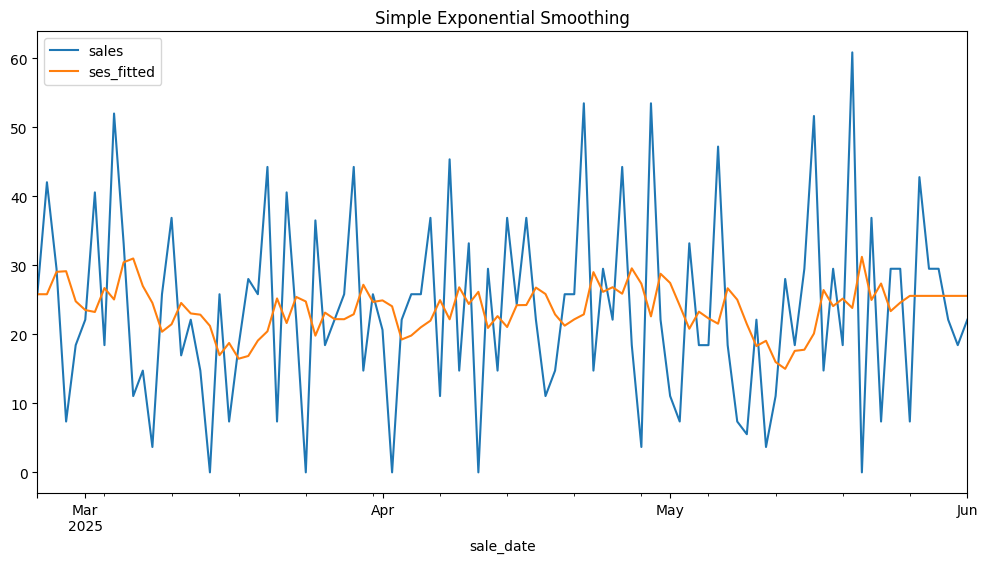

In [53]:
ds.plot(x='sale_date', y=['sales', 'ses_fitted'], figsize=(12, 6), title='Simple Exponential Smoothing')

In [54]:
res.params

{'smoothing_level': 0.2,
 'smoothing_trend': None,
 'smoothing_seasonal': None,
 'damping_trend': nan,
 'initial_level': np.float64(25.830000000000002),
 'initial_trend': np.float64(nan),
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}